In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

rockData = pd.read_csv('rock.csv')

X = rockData[['area', 'peri', 'shape']]
y = rockData[['perm']]

The rockData dataset contains geological data related to rock samples. Each row represents a single rock sample with the following columns:

- area: The surface area of the rock sample.
- peri: The perimeter of the rock sample.
- shape: A shape factor or index that quantifies the geometrical properties of the rock.
- perm: The permeability of the rock sample, i.e. a measure of how easily fluids can pass through the rock.

In [2]:
# performing standardization

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
# adding a column of 1s to the X matrix

X_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

In [ ]:
# This function calculates the mean squared error divided by 2 
# 2 is added for convenience sake and is useful in theoretical calculation of partial derivative

def compute_cost(X, y, theta):
    m = len(y)
    y = y.flatten()
    predictions = X.dot(theta)
    errors = predictions - y
    cost = (1 / (2 * m)) * np.sum(errors ** 2)
    return cost

In [4]:
# defining a function which uses the gradient descent algorithm to compute parametes and cost 
# also requires random initialization of parameters and an alpha value corresponding to the size of the step

def gradient_descent(X, y, theta, alpha, num_iters):
    m = len(y) #number of data points
    y = y.values.flatten()
    J_history = []

    for i in range(num_iters):
        predictions = X.dot(theta)
        errors = predictions - y
        theta = theta - (alpha / m) * X.T.dot(errors)
        J_history.append(compute_cost(X, y, theta))

    return theta, J_history

In [6]:
theta = np.zeros(X_scaled.shape[1]) # all zeroes
alpha = 0.01
num_iters = 500

theta_opt, J_history = gradient_descent(X_scaled, y, theta, alpha, num_iters)

theta_opt

array([ 419.65641771,   74.48731307, -298.01881259,  129.48365217])

In [7]:
import warnings
warnings.filterwarnings('ignore')

#adding a new column fitted_gd with the predicted values 

def predict_perm_gd(area, peri, shape):
    #Normalize the input features
    features = np.array([area, peri, shape]).reshape(1, -1)
    features_scaled = scaler.transform(features)
    features_scaled = np.c_[np.ones(features_scaled.shape[0]), features_scaled]
    
    perm = np.dot(features_scaled, theta_opt)
    return perm[0]

rockData['fitted_gd'] = rockData.apply(lambda row: predict_perm_gd(row['area'], row['peri'], row['shape']), axis=1)

rockData.head()

,area,peri,shape,perm,fitted_gd
0,4990,2791.90,0.090330,6.3,118.864011
1,7002,3892.60,0.148622,6.3,35.854524
2,7558,3930.66,0.183312,6.3,98.788785
3,7352,3869.32,0.117063,6.3,0.241545
4,7943,3948.54,0.122417,17.1,8.648448


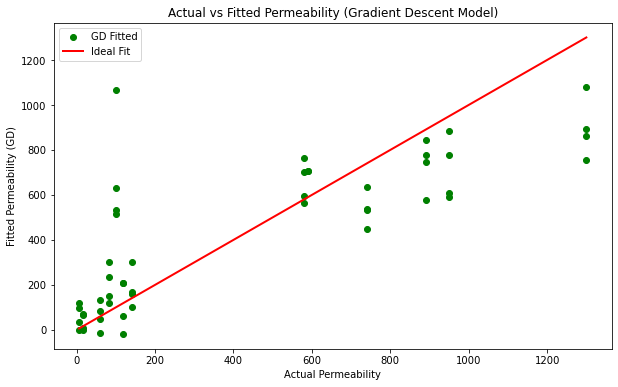

In [8]:
plt.figure(figsize=(10, 6))

plt.scatter(rockData['perm'], rockData['fitted_gd'], color='green', label='GD Fitted')
plt.plot([rockData['perm'].min(), rockData['perm'].max()], [rockData['perm'].min(), rockData['perm'].max()], color='red', lw=2, label='Ideal Fit')
plt.xlabel('Actual Permeability')
plt.ylabel('Fitted Permeability (GD)')
plt.title('Actual vs Fitted Permeability (Gradient Descent Model)')
plt.legend()
plt.show()

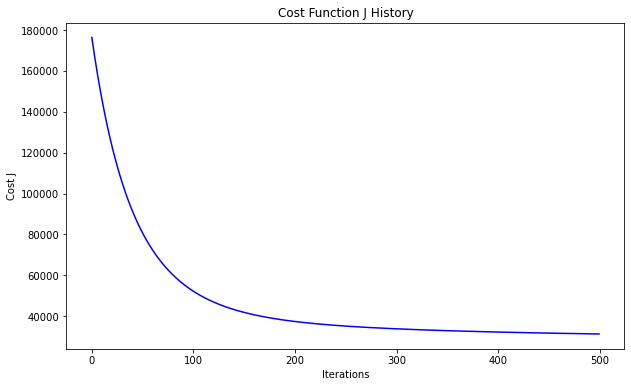

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(J_history, color='blue')
plt.xlabel('Iterations')
plt.ylabel('Cost J')
plt.title('Cost Function J History')
plt.show()

Now, parameters will be estimated using the ordinary least squares (OLS) method.

In [10]:
# Define the OLS model 
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
rockData['fitted_ols'] = ols_model.fittedvalues

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate performance metrics for OLS
mse_ols = mean_squared_error(y, rockData['fitted_ols'])
r2_ols = r2_score(y, rockData['fitted_ols'])

# Calculate performance metrics for Gradient Descent
mse_gd = mean_squared_error(y, rockData['fitted_gd'])
r2_gd = r2_score(y, rockData['fitted_gd'])

# Display performance metrics
performance_metrics = {
    'Model': ['OLS', 'Gradient Descent'],
    'MSE': [mse_ols, mse_gd],
    'R-squared': [r2_ols, r2_gd]
}

performance_df = pd.DataFrame(performance_metrics)

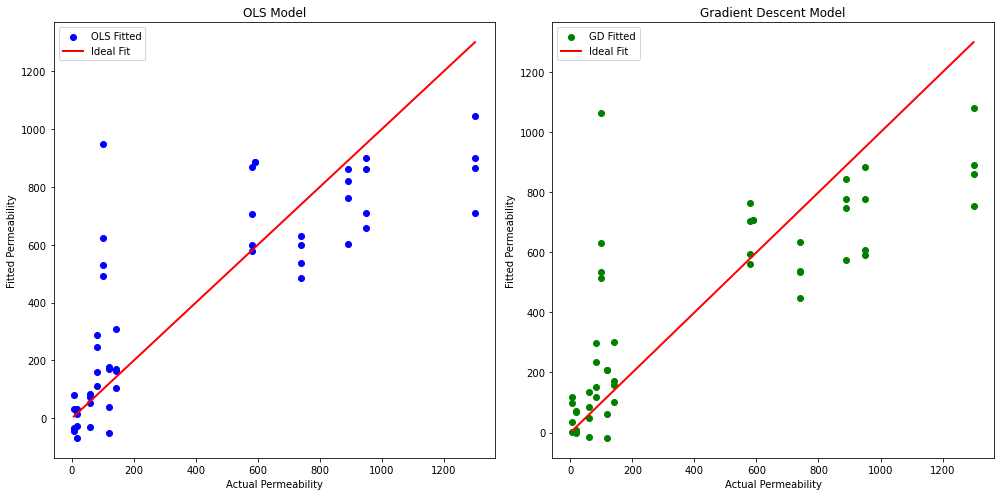

In [12]:
# Plot actual vs fitted values for both models
plt.figure(figsize=(14, 7))

# OLS Plot
plt.subplot(1, 2, 1)
plt.scatter(y, rockData['fitted_ols'], color='blue', label='OLS Fitted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal Fit')
plt.xlabel('Actual Permeability')
plt.ylabel('Fitted Permeability')
plt.title('OLS Model')
plt.legend()

# GD Plot
plt.subplot(1, 2, 2)
plt.scatter(y, rockData['fitted_gd'], color='green', label='GD Fitted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal Fit')
plt.xlabel('Actual Permeability')
plt.ylabel('Fitted Permeability')
plt.title('Gradient Descent Model')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
performance_df

,Model,MSE,R-squared
0,OLS,58944.242651,0.674976
1,Gradient Descent,62579.781190,0.654930


The OLS model achieved a lower MSE (58944.24) and slightly higher R-squared (0.675) compared to the Gradient Descent model, which had an MSE of 62579.78 and R-squared of 0.655. Overall, the Gradient Descent model has performed quite well and provided a competitive fit to the data.

In [26]:
def plot_cost_history(J_history, alpha, num_iters):
    plt.plot(J_history, label=f'alpha={alpha}, iterations={num_iters}')
    plt.xlabel('Iterations')
    plt.ylabel('Cost J')
    plt.title('Cost Function J History')

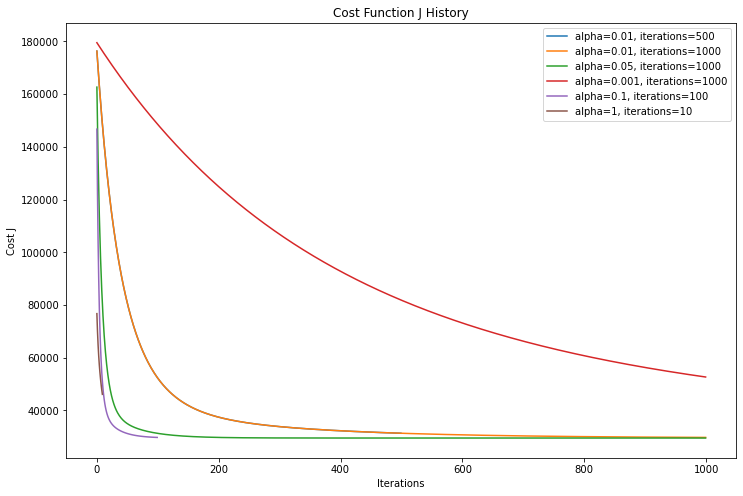

,alpha,iterations,MSE,R-squared
0,0.010,500,62579.781190,0.654930
1,0.010,1000,59414.545494,0.672383
2,0.050,1000,58944.242686,0.674976
3,0.001,1000,105276.075083,0.419499
4,0.100,100,59396.992839,0.672480
5,1.000,10,92114.910980,0.492070


In [29]:
# Checking gradient descent performance for different values of alpha and iterations

combinations = [
    (0.01, 500),
    (0.01, 1000),
    (0.05, 1000),
    (0.001, 1000),
    (0.1, 100),
    (1,10)
]

results = []

plt.figure(figsize=(12, 8))

for alpha, num_iters in combinations:
    theta = np.zeros(X_scaled.shape[1])
    theta_opt, J_history = gradient_descent(X_scaled, y, theta, alpha, num_iters)
    y_pred = X_scaled.dot(theta_opt)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    results.append({'alpha': alpha, 'iterations': num_iters, 'MSE': mse, 'R-squared': r2})
    plot_cost_history(J_history, alpha, num_iters)

plt.legend()
plt.show()

results_df = pd.DataFrame(results)
results_df

### Key Insights:

1. **Optimal Learning Rate and Iterations**:
   - The combination of `alpha=0.05` and `iterations=1000` resulted in the lowest MSE (58944.24) and the highest R-squared value (0.674976). Overall, this combination has the best performance.
   - Higher learning rates (e.g., `alpha=1.0`) with fewer iterations (e.g., 10) led to subpar performance, as shown by higher MSE and lower R-squared values. It suggests that a very high learning rate can cause the gradient descent to overshoot the minimum and lead to suboptimal convergence.

2. **Cost Function Convergence**:
   - The cost function history plot shows that lower learning rates (e.g., `alpha=0.001`) require more iterations to converge, and may not achieve the lowest cost even after 1000 iterations.
   - Conversely, a moderately higher learning rate (e.g., `alpha=0.05`) converges faster and achieves a lower cost within the same number of iterations.

3. **Trade-off Between Learning Rate and Iterations**:
   - Increasing the number of iterations while maintaining a moderate learning rate (e.g., `alpha=0.01` with 1000 iterations) can improve model performance, as shown by the improvement in MSE from 62579.78 to 59414.54 when increasing iterations from 500 to 1000.
   - However, a very low learning rate (e.g., `alpha=0.001` with 1000 iterations) does not give good results, as seen from the high MSE and low R-squared values.

4. **Performance of Gradient Descent**:
   - The Gradient Descent model with the best hyperparameters (`alpha=0.05` and `iterations=1000`) performs comparably to the OLS model.
   - The Gradient Descent model's performance varies significantly with different combinations of learning rates and iterations. In turn, the same shows the importance of tuning the parameters.

### Conclusion
- **Best Performing Configuration**: `alpha=0.05` and `iterations=1000`
- **Importance of Hyperparameter Tuning**: The results highlight the need to carefully select and tune the learning rate and number of iterations to achieve optimal model performance.
- **Comparative Performance**: The OLS model generally provides a good benchmark, but a well-tuned Gradient Descent model can achieve similar performance, making it a robust method for linear regression.